In [9]:
import config_public
import BCQM_public
import helper
import matplotlib.pyplot as plt
import dataprocessing
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Load example data

In [2]:
x = helper.open_pickle('./data/example_model.txt')      # Model timeseries 
y = helper.open_pickle('./data/example_observed.txt')   # Observation timeseries 

# Get historical data x (predictor model) and y (target observation) by overlapping dates
x_hist, y_hist = dataprocessing.intersect(x, y)

# Check dates (1979 - 2017 will be the calibration period)
print(x_hist.index)
print(y_hist.index)

DatetimeIndex(['1979-01-01', '1979-01-02', '1979-01-03', '1979-01-04',
               '1979-01-05', '1979-01-06', '1979-01-07', '1979-01-08',
               '1979-01-09', '1979-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='time', length=14235, freq=None)
DatetimeIndex(['1979-01-01', '1979-01-02', '1979-01-03', '1979-01-04',
               '1979-01-05', '1979-01-06', '1979-01-07', '1979-01-08',
               '1979-01-09', '1979-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='time', length=14235, freq=None)


In [3]:
# Get future model data
x_fut = x[str(x_hist.index[-1].year + 1):'2050']
print(x_fut.index)

# We use quantile mapping bias correction to get future projection y_fut for these dates.
# i.e. learn mapping function y_hist=f(x_hist) to get y_fut=f(x_fut)

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2050-12-22', '2050-12-23', '2050-12-24', '2050-12-25',
               '2050-12-26', '2050-12-27', '2050-12-28', '2050-12-29',
               '2050-12-30', '2050-12-31'],
              dtype='datetime64[ns]', name='time', length=12045, freq=None)


## (1) Load config

### Config() arguments:

#### Detrending method
* MODE=
* 'timeseries': No detrending - does not preserve long term trend of model (not recommended)
* 'detrended_pdf': Robust detrending (detrends using rolling window pdf mean i.e. accounts for difference in trends in different times of year). Default rolling window days: detrend_window_days=31
* 'detrended_polynomial': Polynomial fit detrending. Seasonal differences in long term trend ignored.
(Note: difference in scores is more apparent in perfect sibling test (longer time period) than k-fold)

#### Number of quantiles
* n_quantiles=80: Number of quantiles to map in 'vanilla' quantile mapping. 

#### Data: must be pandas dataframe with 365 days in each year (not tested for incomplete days in a year).
* x_hist: model historical
* y_hist: observed historical
* x_fut: model future

### Other options:

* detrend_order=2: Polynomial order for fitting long term trends in 'detrended_pdf' and 'detrended_polynomial' detrending methods (recommended: 2)
* K=5: Number of folds in K-fold cross validation
* window_days=15: Rolling window days i.e. ±15 from the current day (total 31 datapoints per pdf).

#### Current limitations:
* x_hist and x_fut must be continuous
* Must have 365 days in each year
* Each datapoint in projected timeseries based on average from corrected pdf based on rolling window (default window_days is 15)

In [4]:
conf = config_public.Config(MODE='detrended_pdf',
                            n_quantiles=80,
                            x_hist=x_hist,
                            y_hist=y_hist,
                            x_fut=x_fut,
                            )

Original data loaded.
Processing trend info on 1D data
Processing x
Getting trend data, config.MODE = detrended_pdf...
Processing y
Getting trend data, config.MODE = detrended_pdf...
Loaded config.


## (2) Get bias corrected future projection (optional K-fold validation score)

* (Output) y_fut: future projection

In [5]:
# RUN_KFOLD=True: Option to run K-fold experiments (uses historical period x_hist and y_hist).
# Takes longer - set to False if you just want projection data.

bc = BCQM_public.BiasCorrection(conf)
y_fut = bc.get_projection(RUN_KFOLD=True)

Generating pdf for training data...
Training model...
Correcting x_test timeseries...
Generating pdf for test data...
Done: adjusted result at self.corrected_timeseries (may be in detrended form; not necessarily projection)
Obtaining projected timeseries...
Done: projected timeseries at self.projected_timeseries

Running K-fold cross validation experiment. Set RUN_KFOLD=False to skip.
K = 1/5
Generating pdf for training data...
Training model...
Correcting x_test timeseries...
Generating pdf for test data...
Done: adjusted result at self.corrected_timeseries (may be in detrended form; not necessarily projection)
Comparing corrected timeseries to y_test (truth):
Generating pdf for adjusted & truth data...
Calculating scores...
     RMSE for this k = 0.819240813828467
K = 2/5
Generating pdf for training data...
Training model...
Correcting x_test timeseries...
Generating pdf for test data...
Done: adjusted result at self.corrected_timeseries (may be in detrended form; not necessarily pro

In [6]:
print(y_fut.head())

                  data
date_raw              
2018-01-01  282.773556
2018-01-02  284.224959
2018-01-03  283.917080
2018-01-04  283.759829
2018-01-05  284.181244


### Plot results

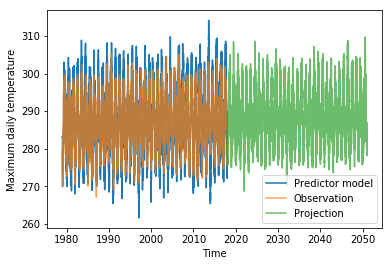

In [11]:
smooth_curves = False
smooth_window = 5
alpha = 0.7

plt.figure()
y_plot = helper.smooth_savgol(x_hist.values.squeeze(), window=smooth_window) if smooth_curves else x_hist.values.squeeze()
plt.plot(x_hist.index,
         y_plot,
         label='Predictor model'
         )

y_plot = helper.smooth_savgol(y_hist.values.squeeze(), window=smooth_window) if smooth_curves else y_hist.values.squeeze()
plt.plot(y_hist.index,
         y_plot,
         alpha=alpha,
         label='Observation'
         )

y_plot = helper.smooth_savgol(y_fut.values.squeeze(), window=smooth_window) if smooth_curves else y_fut.values.squeeze()
plt.plot(y_fut.index,
         y_plot,
         alpha=alpha,
         label='Projection'
         )

plt.xlabel("Time")
plt.ylabel("Maximum daily temperature")
plt.legend()
plt.show()